In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import copy
import seaborn as sb

In [5]:
#loading the training dataset
train_df = pd.read_csv("Gotem Pumpkins.csv", index_col=0)
train_df = pd.get_dummies(train_df, columns=["Class"], drop_first=True)
train_df = train_df.astype({"Class_Ürgüp Sivrisi":"int"})
train_df.drop_duplicates(inplace=True)
train_df.dropna(inplace=True)
print(train_df.head())

     Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Convex_Area  \
0   84930   1204.448           508.7883           213.0266        85665   
1  103343   1275.261           521.4694           252.8941       104156   
2   98350   1269.539           526.2346           238.4702        99184   
3   69517   1059.538           429.8407           206.8250        70493   
4   80011   1182.947           501.9065           204.7531        80902   

   Equiv_Diameter  Eccentricity  Solidity  Extent  Roundness  Aspect_Ration  \
0        328.8407        0.9081    0.9914  0.5482     0.7357         2.3884   
1        362.7401        0.8745    0.9922  0.7457     0.7985         2.0620   
2        353.8688        0.8914    0.9916  0.5919     0.7668         2.2067   
3        297.5093        0.8766    0.9862  0.6623     0.7782         2.0783   
4        319.1758        0.9130    0.9890  0.7374     0.7185         2.4513   

   Compactness  Class_Ürgüp Sivrisi  
0       0.6463                    1 

In [6]:
x_train = train_df.drop("Class_Ürgüp Sivrisi", axis=1)
y_train = train_df.iloc[:,-1].to_numpy()

print(f"\nx Shape: {x_train.shape}, X Type:{type(x_train)})")
print(x_train.head())
print(f"\ny Shape: {y_train.shape}, y Type:{type(y_train)})")
print(y_train[:5])


x Shape: (2000, 12), X Type:<class 'pandas.core.frame.DataFrame'>)
     Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Convex_Area  \
0   84930   1204.448           508.7883           213.0266        85665   
1  103343   1275.261           521.4694           252.8941       104156   
2   98350   1269.539           526.2346           238.4702        99184   
3   69517   1059.538           429.8407           206.8250        70493   
4   80011   1182.947           501.9065           204.7531        80902   

   Equiv_Diameter  Eccentricity  Solidity  Extent  Roundness  Aspect_Ration  \
0        328.8407        0.9081    0.9914  0.5482     0.7357         2.3884   
1        362.7401        0.8745    0.9922  0.7457     0.7985         2.0620   
2        353.8688        0.8914    0.9916  0.5919     0.7668         2.2067   
3        297.5093        0.8766    0.9862  0.6623     0.7782         2.0783   
4        319.1758        0.9130    0.9890  0.7374     0.7185         2.4513   

   Com

In [7]:
#z score normalisation - feature scaling
x_mu = np.mean(x_train,axis=0)
x_sigma = np.std(x_train, axis=0)
x_sigma[x_sigma == 0] = 1  #replace zero standard deviations with 1 because all values identical(avoid division by 0)
x_norm = ((x_train - x_mu)/x_sigma).to_numpy()
print(f"X_mu = \n{x_mu}, \n\nX_sigma = \n{x_sigma}\n\n")
print(f"\nPeak to Peak range by column in Raw        X:\n{np.ptp(x_train,axis=0)}") #range of each col
print(f"\nPeak to Peak range by column in Normalized X:\n{np.ptp(x_norm,axis=0)}")

X_mu = 
Area                 80641.462500
Perimeter             1130.261905
Major_Axis_Length      456.638748
Minor_Axis_Length      225.707590
Convex_Area          81495.589000
Equiv_Diameter         319.289997
Eccentricity             0.861151
Solidity                 0.989427
Extent                   0.694210
Roundness                0.791254
Aspect_Ration            2.042135
Compactness              0.703924
dtype: float64, 

X_sigma = 
Area                 13715.952455
Perimeter              109.304507
Major_Axis_Length       56.317078
Minor_Axis_Length       23.157882
Convex_Area          13812.946035
Equiv_Diameter          27.014764
Eccentricity             0.044500
Solidity                 0.003636
Extent                   0.060165
Roundness                0.055334
Aspect_Ration            0.313875
Compactness              0.052535
dtype: float64



Peak to Peak range by column in Raw        X:
Area                 88635.0000
Perimeter              690.9650
Major_Axis_Length  

In [8]:
#defining sigmoid function
def sigmoid(z):
  g = 1/(1 + np.exp(-z))
  return g

In [9]:
#defining function to compute total cost of all iterations
def compute_cost_logistic(X, y, w, b, lambda_ = 1):
    m,n  = X.shape
    cost = 0.
    for i in range(m):
        z_i = np.dot(X[i], w)+b
        f_wb_i = sigmoid(z_i)
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)

    cost/= m

    reg_cost = 0
    for j in range(n):
        reg_cost+= (w[j]**2)
    reg_cost = (lambda_/(2*m))*reg_cost

    total_cost = cost + reg_cost
    return total_cost

In [10]:
#function to compute gradient of a single iteration
def compute_gradient_logistic(X, y, w, b):
  m,n = X.shape
  dj_dw = np.zeros((n,))
  dj_db = 0.

  for i in range(m):
    f_wb_i = sigmoid(np.dot(X[i],w) + b)
    err_i  = f_wb_i  - y[i]
    for j in range(n):
      dj_dw[j] = dj_dw[j] + err_i*X[i,j]
      dj_db = dj_db + err_i
  dj_dw = dj_dw/m
  dj_db = dj_db/m

  return dj_db, dj_dw

In [11]:
#function for gradient descent
def grad_desc(X, y, w_in, b_in, alpha, iters):
  J_history = []
  w = copy.deepcopy(w_in)  #avoid modifying global w within function
  b = b_in

  for i in range(1,iters+1):
    dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)
    w = w - alpha * dj_dw
    b = b - alpha * dj_db
    if i<100000:      #preventing resource exhaustion
      J_history.append( compute_cost_logistic(X, y, w, b) )
    if i% math.ceil(iters / 10) == 0:
      print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")

  return w, b, J_history

In [12]:
test_df = pd.read_csv("Freyja_Pumpkins.csv", index_col=0)
test_df = pd.get_dummies(test_df, columns=["Class"], drop_first=True)
test_df = test_df.astype({"Class_Ürgüp Sivrisi":"int"})
test_df.drop_duplicates(inplace=True)
test_df.dropna(inplace=True)

x_test = test_df.drop("Class_Ürgüp Sivrisi", axis=1)
y_test = test_df.iloc[:,-1].to_numpy()

In [13]:
#normalising the testing data
x_mu_t = np.mean(x_test,axis=0)
x_sigma_t = np.std(x_test, axis=0)
x_sigma_t[x_sigma_t == 0] = 1  #replace zero standard deviations with 1 because all values identical(avoid division by 0)
x_norm_t = ((x_test - x_mu_t)/x_sigma_t).to_numpy()
print(f"X_mu = \n{x_mu_t}, \n\nX_sigma = \n{x_sigma_t}\n\n")
print(f"\nPeak to Peak range by column in Raw        X:\n{np.ptp(x_test,axis=0)}") #range of each col
print(f"\nPeak to Peak range by column in Normalized X:\n{np.ptp(x_norm_t,axis=0)}")

X_mu = 
Area                 80725.254000
Perimeter             1130.347452
Major_Axis_Length      456.454207
Minor_Axis_Length      226.144247
Convex_Area          81558.066000
Equiv_Diameter         319.511164
Eccentricity             0.859791
Solidity                 0.989749
Extent                   0.689183
Roundness                0.792646
Aspect_Ration            2.039970
Compactness              0.704908
dtype: float64, 

X_sigma = 
Area                 13442.683414
Perimeter              108.954319
Major_Axis_Length       55.852185
Minor_Axis_Length       23.820580
Convex_Area          13552.834226
Equiv_Diameter          26.366672
Eccentricity             0.047685
Solidity                 0.002834
Extent                   0.063603
Roundness                0.058156
Aspect_Ration            0.324034
Compactness              0.055085
dtype: float64



Peak to Peak range by column in Raw        X:
Area                 84785.0000
Perimeter              632.2830
Major_Axis_Length  

In [14]:
#initialising
w_init = np.zeros(x_train.shape[1])
b_init = 0.
iterations = 1000
lambda_ = 0

In [23]:
#finding optimal alpha
alphas = [0.001, 0.003, 0.01, 0.03, 0.1,0.3,1]
alpha_iter = 200
best_alpha = None
lowest_cost = float('inf')
J_hist_alpha = []

for alpha in alphas:
    w_final, b_final, J_hist = grad_desc(x_norm, y_train, w_init, b_init, alpha, alpha_iter)
    final_cost = J_hist[-1]
    J_hist_alpha.append(final_cost)
    print(f"Alpha: {alpha}, Final Cost: {final_cost}")

    if final_cost < lowest_cost:
        lowest_cost = final_cost
        best_alpha = alpha

print(f"Optimal Learning Rate: {best_alpha}")

Iteration   20: Cost 0.6798172090695638   
Iteration   40: Cost 0.6671918116961358   
Iteration   60: Cost 0.6552309217105187   
Iteration   80: Cost 0.6438959678251004   
Iteration  100: Cost 0.6331500133092096   
Iteration  120: Cost 0.6229578490637266   
Iteration  140: Cost 0.6132860466521346   
Iteration  160: Cost 0.6041029774511666   
Iteration  180: Cost 0.5953788039156174   
Iteration  200: Cost 0.5870854485462826   
Alpha: 0.001, Final Cost: 0.5870854485462826
Iteration   20: Cost 0.6551836572705264   
Iteration   40: Cost 0.6228782575718876   
Iteration   60: Cost 0.5952781517208454   
Iteration   80: Cost 0.5715738801862277   
Iteration  100: Cost 0.5510938883333228   
Iteration  120: Cost 0.5332886655848391   
Iteration  140: Cost 0.5177116164379804   
Iteration  160: Cost 0.5040005199906723   
Iteration  180: Cost 0.4918612462373439   
Iteration  200: Cost 0.4810541811294653   
Alpha: 0.003, Final Cost: 0.4810541811294653
Iteration   20: Cost 0.586607209035387   
Iteratio

In [ ]:
#plotting variation of final cost with learning rate
plt.plot(alphas, J_hist_alpha, marker='.')
plt.xlabel("Alpha (Learning Rate)")
plt.ylabel("Final Cost")
plt.title("Learning Rate vs Cost")
plt.show()

In [16]:
#gradient at initial weights
tmp_dj_db, tmp_dj_dw = compute_gradient_logistic(x_norm, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

dj_db at initial w,b: 0.192
dj_dw at initial w,b: 
 [-0.08559126 -0.19205489 -0.27825229  0.19762236 -0.08447719 -0.0808151
 -0.34943529 -0.05963228  0.10727929  0.33060309 -0.35934302  0.36236265]


In [17]:
w_final, b_final, J_hist = grad_desc(x_norm, y_train, w_init, b_init, best_alpha, iterations)

Iteration  100: Cost 0.3248307741058156   
Iteration  200: Cost 0.323364272597118   
Iteration  300: Cost 0.32212991685248266   
Iteration  400: Cost 0.32106944973566576   
Iteration  500: Cost 0.3201551022173691   
Iteration  600: Cost 0.3193698367419729   
Iteration  700: Cost 0.31870080418851277   
Iteration  800: Cost 0.3181371861253014   
Iteration  900: Cost 0.3176694924644969   
Iteration 1000: Cost 0.31728934163745665   


In [27]:
sigmoid_predictions = sigmoid(np.dot(x_norm_t, w_final) + b_final)
predictions = [1 if value >= 0.5 else 0 for value in sigmoid_predictions] #converting value from numerical to either 0 or 1

print("Running on testing data:\n")
for i in range(0,len(predictions),50): #printing predictions at an interval of 50 to reduce length of output. confusion matrix of all predictions plotted later
    print(f"Prediction #{i+1}: {predictions[i]}\t\tActual value: {y_test[i]}")

Running on testing data:

Prediction #1: 0		Actual value: 0
Prediction #51: 1		Actual value: 1
Prediction #101: 0		Actual value: 0
Prediction #151: 0		Actual value: 0
Prediction #201: 1		Actual value: 1
Prediction #251: 0		Actual value: 0
Prediction #301: 0		Actual value: 0
Prediction #351: 0		Actual value: 0
Prediction #401: 0		Actual value: 0
Prediction #451: 0		Actual value: 1


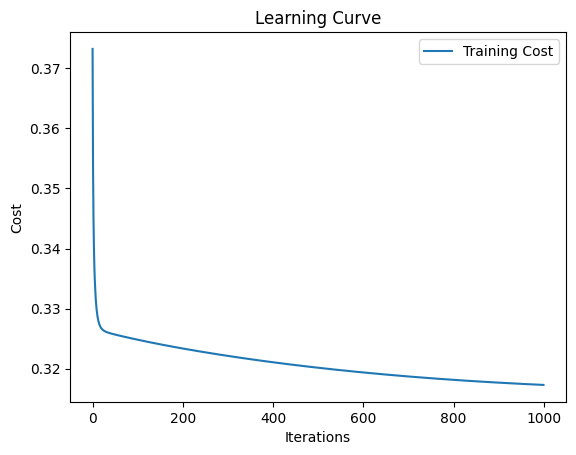

In [19]:
plt.plot(J_hist, label="Training Cost")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Learning Curve")
plt.legend()
plt.show()

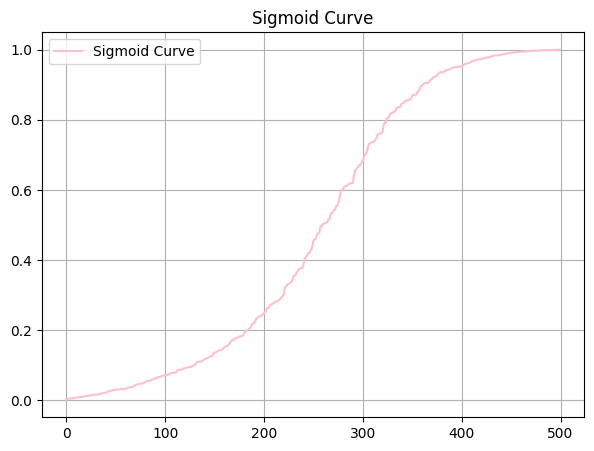

In [20]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(sorted(sigmoid_predictions), color="pink", label="Sigmoid Curve")
ax.set_title("Sigmoid Curve")
ax.grid(True)
ax.legend()
plt.show()

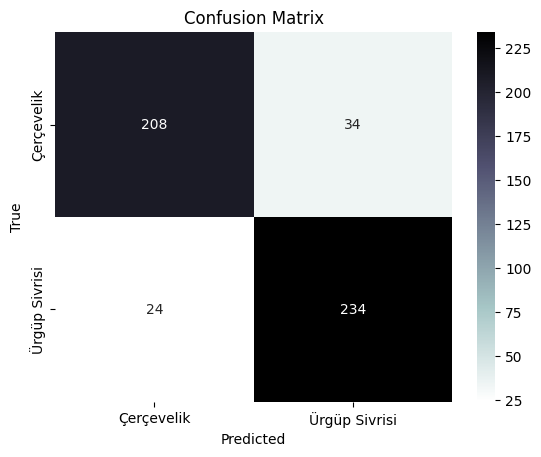

In [28]:
predictions = np.array(predictions)
TP = np.sum((y_test==1) & (predictions==1))
TN = np.sum((y_test==0) & (predictions==0))
FP = np.sum((y_test==0) & (predictions==1))
FN = np.sum((y_test==1) & (predictions==0))
cm = [[TP, FP], [FN, TN]]
plt.title('Confusion Matrix')
sb.heatmap(cm, annot=True, fmt='d', cmap='bone_r', xticklabels=['Çerçevelik', 'Ürgüp Sivrisi'], yticklabels=['Çerçevelik', 'Ürgüp Sivrisi'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [30]:
print(f"The model is {(TP+TN)/len(y_test)*100}% accurate.")

The model is 88.4% accurate.
